# Short-term Energy Load Forecasting

This notebook forecasts hourly electricity load for a building and detects anomalies in usage.
It uses a feature-engineered Gradient Boosting model (scikit-learn) and a simple z-score residual method for anomaly detection.


In [1]:
# Setup
# If running locally, install requirements once in your environment:
#   pip install -r requirements.txt

import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Config
DATA_PATH = "dataset.csv"
RANDOM_STATE = 42


In [2]:
# Load dataset
df = pd.read_csv(DATA_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
df.head()

,timestamp,building_id,load_kw
0,2025-06-01 00:00:00,BLDG_A,1.060
1,2025-06-01 01:00:00,BLDG_A,1.009
2,2025-06-01 02:00:00,BLDG_A,1.072
3,2025-06-01 03:00:00,BLDG_A,1.142
4,2025-06-01 04:00:00,BLDG_A,1.002


## Feature engineering

We create time-based features (hour, day of week, weekend flag), lag features, and rolling averages.


In [3]:
def make_features(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

    # Lags and rolling means
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'lag_{lag}'] = df['load_kw'].shift(lag)
    for win in [3, 6, 12, 24]:
        df[f'rollmean_{win}'] = df['load_kw'].shift(1).rolling(win).mean()

    df = df.dropna().reset_index(drop=True)
    return df

feat_df = make_features(df)
feat_df.head()

,timestamp,building_id,load_kw,hour,dayofweek,is_weekend,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,rollmean_3,rollmean_6,rollmean_12,rollmean_24
0,2025-06-02 00:00:00,BLDG_A,1.161,0,0,0,0.911,1.030,2.366,2.311,2.402,1.060,1.435667,1.898333,2.109667,1.747208
1,2025-06-02 01:00:00,BLDG_A,1.214,1,0,0,1.161,0.911,1.030,2.271,2.230,1.009,1.034000,1.706667,2.006250,1.751417
2,2025-06-02 02:00:00,BLDG_A,1.113,2,0,0,1.214,1.161,0.911,2.501,2.245,1.072,1.095333,1.530500,1.921583,1.759958
3,2025-06-02 03:00:00,BLDG_A,1.236,3,0,0,1.113,1.214,1.161,2.366,2.338,1.142,1.162667,1.299167,1.827250,1.761667
4,2025-06-02 04:00:00,BLDG_A,1.158,4,0,0,1.236,1.113,1.214,1.030,2.302,1.002,1.187667,1.110833,1.735417,1.765583


## Train / test split

We reserve the last 7 days for testing and train on earlier data.


In [4]:
max_ts = feat_df['timestamp'].max()
split_point = max_ts - pd.Timedelta(days=7)

train = feat_df[feat_df['timestamp'] <= split_point].copy()
test = feat_df[feat_df['timestamp'] > split_point].copy()

features = [c for c in feat_df.columns if c not in ['timestamp', 'building_id', 'load_kw']]

len(train), len(test), features[:8]

(1248,
 168,
 ['hour',
  'dayofweek',
  'is_weekend',
  'lag_1',
  'lag_2',
  'lag_3',
  'lag_6',
  'lag_12'])

## Train model

We use scikit-learn's GradientBoostingRegressor. It handles nonlinearities and is lightweight enough to run quickly.


In [5]:
model = GradientBoostingRegressor(random_state=RANDOM_STATE)
model.fit(train[features], train['load_kw'])

test['y_pred'] = model.predict(test[features])

mae = mean_absolute_error(test['load_kw'], test['y_pred'])
r2 = r2_score(test['load_kw'], test['y_pred'])
mae, r2

(0.0790701273812604, 0.9843847184781498)

## Plot: Actual vs Predicted (Test set)


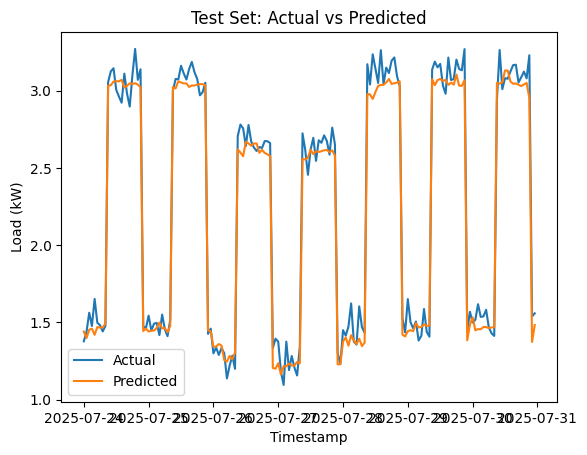

In [6]:
plt.figure()
plt.plot(test['timestamp'], test['load_kw'], label='Actual')
plt.plot(test['timestamp'], test['y_pred'], label='Predicted')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Load (kW)')
plt.legend()
plt.show()

## Anomaly detection

We compute residuals on the test set and flag points with |z-score| > 2.5 as anomalies.


In [7]:
residuals = test['load_kw'] - test['y_pred']
mu = residuals.mean()
sigma = residuals.std(ddof=1) if residuals.std(ddof=1) != 0 else 1.0
z = (residuals - mu) / sigma
test['anomaly'] = (np.abs(z) > 2.5).astype(int)
test[['timestamp', 'load_kw', 'y_pred', 'anomaly']].head()

,timestamp,load_kw,y_pred,anomaly
1248,2025-07-24 00:00:00,1.378,1.441358,0
1249,2025-07-24 01:00:00,1.440,1.399200,0
1250,2025-07-24 02:00:00,1.563,1.453093,0
1251,2025-07-24 03:00:00,1.477,1.459111,0
1252,2025-07-24 04:00:00,1.652,1.420316,0


## Plot: Anomalies


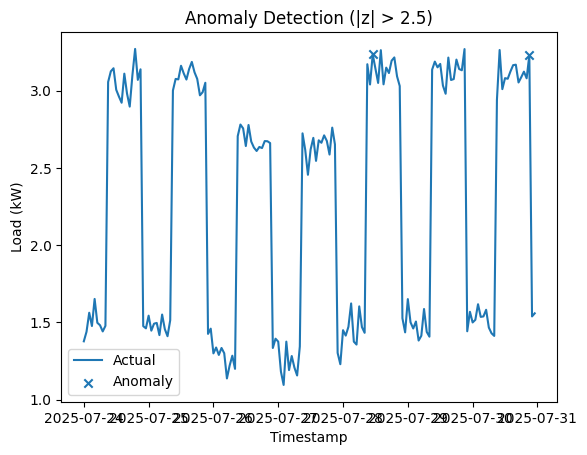

In [8]:
plt.figure()
plt.plot(test['timestamp'], test['load_kw'], label='Actual')
anom = test[test['anomaly'] == 1]
if len(anom) > 0:
    plt.scatter(anom['timestamp'], anom['load_kw'], label='Anomaly', marker='x')
plt.title('Anomaly Detection (|z| > 2.5)')
plt.xlabel('Timestamp')
plt.ylabel('Load (kW)')
plt.legend()
plt.show()

## Forecast next 24 hours

We generate the next 24 timestamps after the last available point and forecast recursively using the trained model, updating lag features with predicted values.


In [9]:
def forecast_next_24(df_full, model, features):
    df = df_full.copy()
    last_ts = df['timestamp'].max()
    horizon = 24
    future_rows = []
    df_work = df.copy()

    for h in range(1, horizon + 1):
        ts = last_ts + pd.Timedelta(hours=h)
        row = {'timestamp': ts, 'building_id': df['building_id'].iloc[-1]}

        # Rebuild features using current df_work
        tmp = df_work.copy()
        tmp = tmp.sort_values('timestamp')
        tmp['hour'] = tmp['timestamp'].dt.hour
        tmp['dayofweek'] = tmp['timestamp'].dt.dayofweek
        tmp['is_weekend'] = tmp['dayofweek'].isin([5, 6]).astype(int)
        for lag in [1, 2, 3, 6, 12, 24]:
            tmp[f'lag_{lag}'] = tmp['load_kw'].shift(lag)
        for win in [3, 6, 12, 24]:
            tmp[f'rollmean_{win}'] = tmp['load_kw'].shift(1).rolling(win).mean()
        tmp = tmp.dropna()
        last_feat = tmp.iloc[-1:].copy()

        # Override time features for forecast timestamp
        last_feat['timestamp'] = ts
        last_feat['hour'] = ts.hour
        last_feat['dayofweek'] = ts.dayofweek
        last_feat['is_weekend'] = int(ts.dayofweek in [5, 6])

        y_pred = model.predict(last_feat[features])[0]
        row['load_kw'] = y_pred
        future_rows.append(row)

        df_work = pd.concat([df_work, pd.DataFrame([row])], ignore_index=True)

    return pd.DataFrame(future_rows)

future_df = forecast_next_24(feat_df[['timestamp', 'building_id', 'load_kw']], model, features)
future_df.head()

,timestamp,building_id,load_kw
0,2025-07-31 00:00:00,BLDG_A,1.491410
1,2025-07-31 01:00:00,BLDG_A,1.484252
2,2025-07-31 02:00:00,BLDG_A,1.448891
3,2025-07-31 03:00:00,BLDG_A,1.485804
4,2025-07-31 04:00:00,BLDG_A,1.455929


## Plot: Next 24 hours forecast


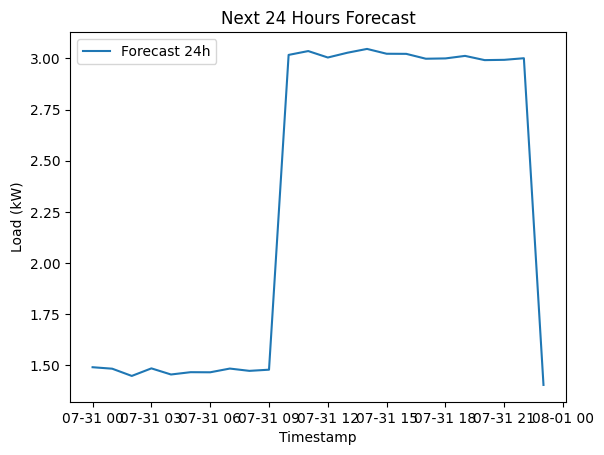

In [10]:
plt.figure()
plt.plot(future_df['timestamp'], future_df['load_kw'], label='Forecast 24h')
plt.title('Next 24 Hours Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Load (kW)')
plt.legend()
plt.show()